In [1]:
from tqdm.notebook import tqdm
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist

In [2]:
nltk.download('stopwords')
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bo112\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bo112\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bo112\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bo112\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bo112\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Data analysis (biography)

In [3]:
df = pd.read_parquet('data/text_data.parquet.gzip')
# df = df.loc[df['id'].str[0] == 'f']

In [4]:
df['split_text'] = df['text'].apply(lambda x: re.split(' |\.|,|;|!|\?|\"|/|\(|\)|\[|]|&|:|-|\' |=', x.lower()))

In [4]:
df_word_counts = df['split_text'].explode().value_counts()
relevant_words = set(df_word_counts.loc[(df_word_counts >= 10) & (df_word_counts <= 2000)].index)
# relevant_words

In [5]:
word_ratings_temp = {}
def word_to_rating(row):
    for word in row['split_text']:
        if word in word_ratings_temp:
            word_ratings_temp[word].append(row['avg_rating'])
        else:
            word_ratings_temp[word] = [row['avg_rating']]

In [6]:
test = df.apply(lambda x: word_to_rating(x), axis=1)

In [7]:
word_ratings = {'word': [], 'avg_rating': []}
for word, ratings in word_ratings_temp.items():
    if word in relevant_words:
        word_ratings['word'].append(word)
        word_ratings['avg_rating'].append(np.mean(ratings))
df_word_ratings = pd.DataFrame(word_ratings)

In [8]:
df.loc[df['text'].str.contains('basketball')]

,id,number_ratings,avg_rating,text,split_text
185,f_0186,12455,9.8,"I'm a Dancer,Gymnastics,i play rugby,volleybal...","[i'm, a, dancer, gymnastics, i, play, rugby, v..."
367,f_0368,4970,9.8,so i like sports i used to do cheerleading i l...,"[so, i, like, sports, i, used, to, do, cheerle..."
522,f_0523,11558,9.2,hey im jessica im 5 5 and yes i no im short i ...,"[hey, im, jessica, im, 5, 5, and, yes, i, no, ..."
695,f_0696,7324,9.8,"Hey I'm Amanda. Im a very sweet, funny, and cu...","[hey, i'm, amanda, , im, a, very, sweet, , fun..."
834,f_0835,15289,9.4,"I'm an easy going person. I like camping, tra...","[i'm, an, easy, going, person, , , i, like, ca..."
862,f_0863,8427,9.4,"I enjoy life, play guitar, love basketball, an...","[i, enjoy, life, , play, guitar, , love, baske..."
1188,m_0189,11371,9.1,"Hi Im Jason. Im originally from Pittsburgh, P...","[hi, im, jason, , , im, originally, from, pitt..."
1425,m_0426,111,9.4,"My name is Isaac, im almost 20 and going to co...","[my, name, is, isaac, , im, almost, 20, and, g..."
1649,m_0650,4055,8.9,Hey What's up..I'm Jay. I like to hang out wit...,"[hey, what's, up, , i'm, jay, , i, like, to, h..."
1675,m_0676,785,9.6,"utica, ny. interests include basketball, shawn...","[utica, , ny, , interests, include, basketball..."


In [10]:
df_word_ratings.sort_values(by='avg_rating', ascending=False, inplace=True)
df_word_ratings

,word,avg_rating
636,basketball,9.430769
391,absolutely,9.416667
637,basically,9.381818
223,characters,9.370000
674,gym,9.364706
...,...,...
363,wit,7.983333
249,become,7.921429
271,female,7.911765
555,boyfriend,7.853846


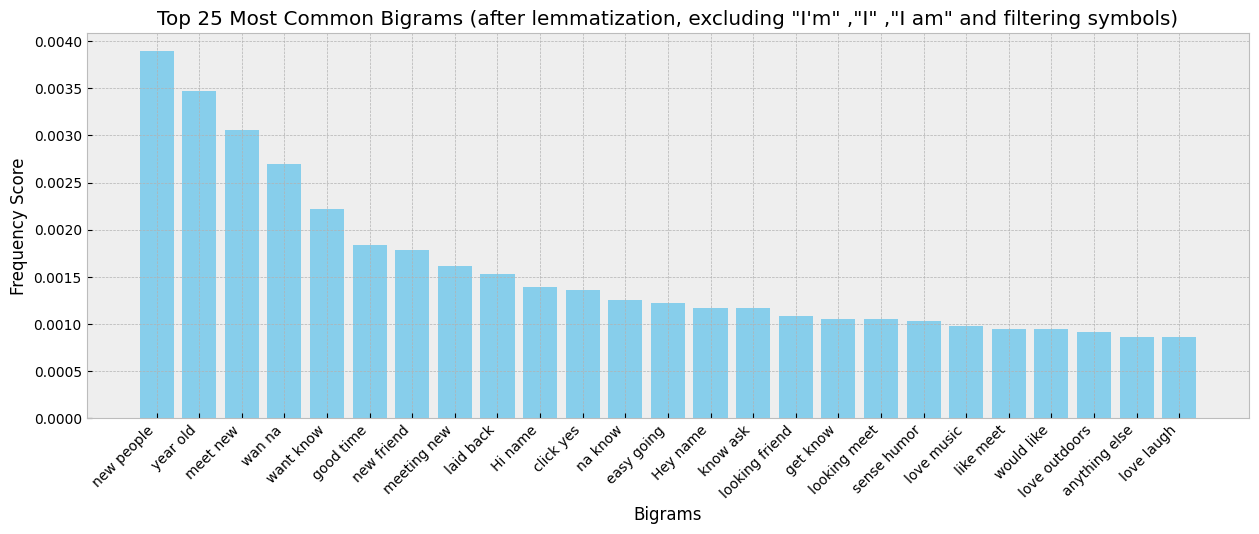

In [6]:
# Tokenize words, perform lemmatization, and remove stopwords
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    words = nltk.word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words if word.lower() not in stop_words and word.lower() not in ["i'm", "i am",'I']]
    # Filter out non-alphabetic characters
    words = [word for word in words if re.match('^[a-zA-Z]+$', word)]
    return words

df['tokenized_text'] = df['text'].apply(preprocess_text)

# Combine all tokenized texts into one list of words
all_words = [word for sublist in df['tokenized_text'] for word in sublist]

# Instantiating the score of each bigram
bigram_meas = BigramAssocMeasures()

# Finding and ranking the Bigrams in the combined text
bio_finder = BigramCollocationFinder.from_words(all_words)

# Finding the frequency scores of each bigram 
bio_scored = bio_finder.score_ngrams(bigram_meas.raw_freq)

# Top 25 most common bigrams
top_bigrams = bio_scored[:25]

# Creating a list of the bigrams
bg = [' '.join(bigram) for bigram, score in top_bigrams]

# Creating a list of the frequency scores
bio_scores = [score for bigram, score in top_bigrams]

# Plotting the bigrams and their frequency scores
plt.style.use('bmh')
plt.figure(figsize=(15, 5))

plt.bar(bg, bio_scores, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.title('Top 25 Most Common Bigrams (after lemmatization, excluding "I\'m" ,"I" ,"I am" and filtering symbols)')
plt.xlabel('Bigrams')
plt.ylabel('Frequency Score')
plt.show()


Number of unique words:  6419


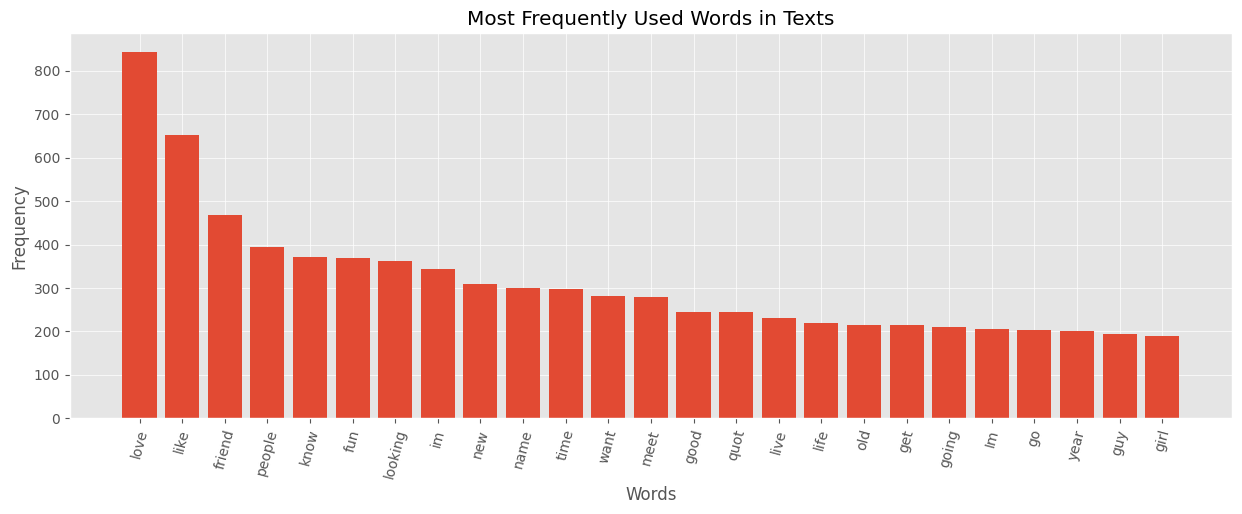

In [7]:
# Combine all tokenized texts into one list of words
all_words = [word for sublist in df['tokenized_text'] for word in sublist]

# Creating a set list that will only take in unique words
total_vocab = set(all_words)

# Printing out the number of unique words in all the texts combined
print("Number of unique words: ", len(total_vocab))

# Determining the use frequency of each word in all the texts
word_freq = FreqDist(all_words)

# Plotting the most frequently used words
plt.style.use('ggplot')
plt.figure(figsize=(15, 5))

plt.bar(*zip(*word_freq.most_common(25)))
plt.xticks(rotation=75)
plt.title('Most Frequently Used Words in Texts')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

In [8]:
# Top 25 most common bigrams
top_bigrams = bio_scored[:20]

# Creating a list of the bigrams
bg = [' '.join(bigram) for bigram, score in top_bigrams]

bg_ratings_temp = {x: [] for x in bg}
def bigram_to_rating(row):
    for bigram in bg:
        if bigram in row['text'].lower():
            bg_ratings_temp[bigram].append(row['avg_rating'])

df.apply(lambda x: bigram_to_rating(x), axis=1)

bg_ratings = {'bigram': [], 'avg_rating': []}
for bigram, ratings in bg_ratings_temp.items():
    bg_ratings['bigram'].append(bigram)
    bg_ratings['avg_rating'].append(np.mean(ratings))
df_bg_ratings = pd.DataFrame(bg_ratings)

C:\Users\bo112\PycharmProjects\ML-Project\venv\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\bo112\PycharmProjects\ML-Project\venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
